In [3]:
import numpy
import json
import matplotlib.pyplot as plt
from tifffile import TiffFile,imread
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [4]:
# add the path to the module
import sys
sys.path.append('/home/wanqing.yu/AC_Project/ac_materialization/flattening_code/')
from surface_detection import get_zarr_group,detect_surface

In [5]:
from skimage.io import imsave
def write_array_to_tiff(tiffpath,arr,exclude=None):
    for i in range(arr.shape[0]):
        if not (not exclude is None and i in exclude):
            imsave(tiffpath,arr[i,...],append=True,bigtiff=True)

# Function to get voxel resolution for a given mip level
def get_voxel_resolution(grp, mip_level):
    # Access the metadata
    metadata = grp.attrs.asdict()
    
    # Retrieve the voxel resolution for the specified mip level
    voxel_resolution = metadata['multiscales'][0]['datasets'][mip_level]['coordinateTransformations'][0]['scale']
    
    return voxel_resolution
            
def read_file(fpath):
    with TiffFile(fpath,is_ome=False) as tf:
        pg = tf.pages[0]
        data = numpy.zeros((pg.shape[0],pg.shape[1],len(tf.pages)),dtype=pg.dtype)
        for i,page in enumerate(tf.pages):
            data[:,:,i] = page.asarray()
    return data

In [6]:
# get mip data from zarr
zarr = "/ACdata/Users/kevin/exaspim_ome_zarr/output_exa4/test.zarr/"
tile = "tile_x_0002_y_0001_z_0000_ch_488"
grp = get_zarr_group(zarr,tile)

# :,:,: is for entire tile, but cutout can be made by indexing on spatial axes
miplvl = 4
mipdata = grp[miplvl][0,0,:,:,:].transpose((2,1,0))

In [7]:
mipdata = grp[miplvl][0,0,:,:,:]

In [8]:
mipdata.shape

(384, 672, 888)

In [9]:
mipdata.shape[1],mipdata.shape[2]

(672, 888)

In [10]:
# detect surface of the mip data
def detect_surface(mipdata):
    # detect surface
    surface = numpy.zeros((mipdata.shape[1],mipdata.shape[2]),dtype=numpy.int32)
    for i in range(mipdata.shape[1]):
        for j in range(mipdata.shape[2]):
            peaks, values = find_peaks(mipdata[:,i,j], prominence=100)
            if len(peaks) > 1:
                peaks = peaks[values['prominences'].argsort()[-2:]]
                surface[i,j] = numpy.round((peaks[0] + peaks[1]) / 2)
    return surface.astype(numpy.int32)

def compute_shifts(surface):
    # Compute shifts to flatten the surface
    reference_level = numpy.median(surface[surface > 0])
    # replace the zero values with the reference level
    surface[surface == 0] = reference_level.astype(int)

    shifts = surface - reference_level
    return shifts.astype(int)

def apply_shifts(data, shifts):
    flattened_data = numpy.zeros_like(data)
    for i in range(mipdata.shape[1]):
        for j in range(mipdata.shape[2]):
            shift = shifts[i, j]
            if shift < 0:
                flattened_data[-shift:, i, j] = mipdata[:shift, i, j]
            elif shift == 0:
                flattened_data[:, i, j] = mipdata[:, i, j]
            else:
                flattened_data[:-shift, i, j] = mipdata[shift:, i, j]
    return flattened_data

In [11]:
surface = detect_surface(mipdata)
surface.shape

(672, 888)

In [12]:
surface

array([[245, 244,   0, ..., 170, 169,   0],
       [  0,   0,   0, ..., 170, 169,   0],
       [  0, 246, 245, ..., 170, 170,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

218.0

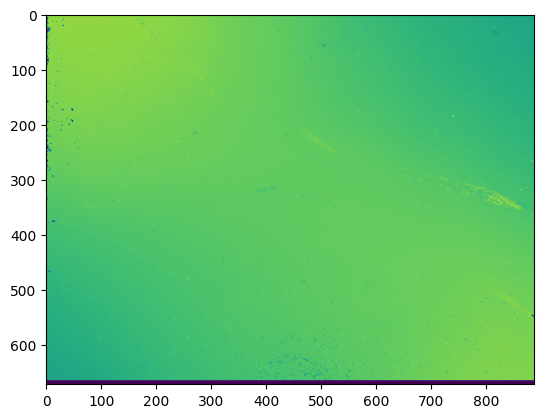

In [13]:
plt.imshow(surface)
numpy.median(surface)

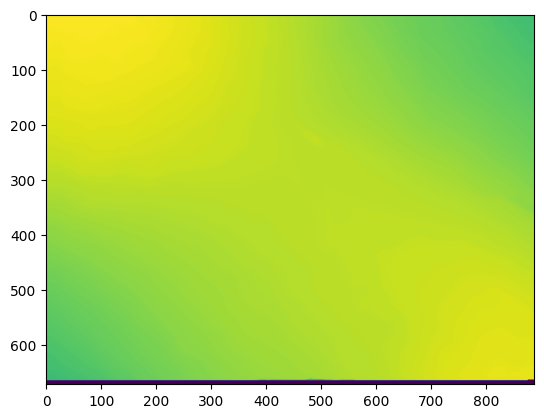

In [14]:
# smooth the surface with median filter
from scipy.ndimage import median_filter
surface_smooth = median_filter(surface, size=25)
plt.imshow(surface_smooth)


In [15]:
shifts = compute_shifts(surface_smooth)
shifts

array([[ 27,  27,  26, ..., -48, -48, -48],
       [ 27,  27,  26, ..., -48, -48, -48],
       [ 27,  27,  26, ..., -48, -48, -48],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [16]:
flatten_data = apply_shifts(mipdata,shifts)
flatten_data.shape

(384, 672, 888)

In [57]:
write_array_to_tiff("flattened_v4.tif",flatten_data)

/tmp/ipykernel_2249591/3376891948.py:5: UserWarning: flattened_v4.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


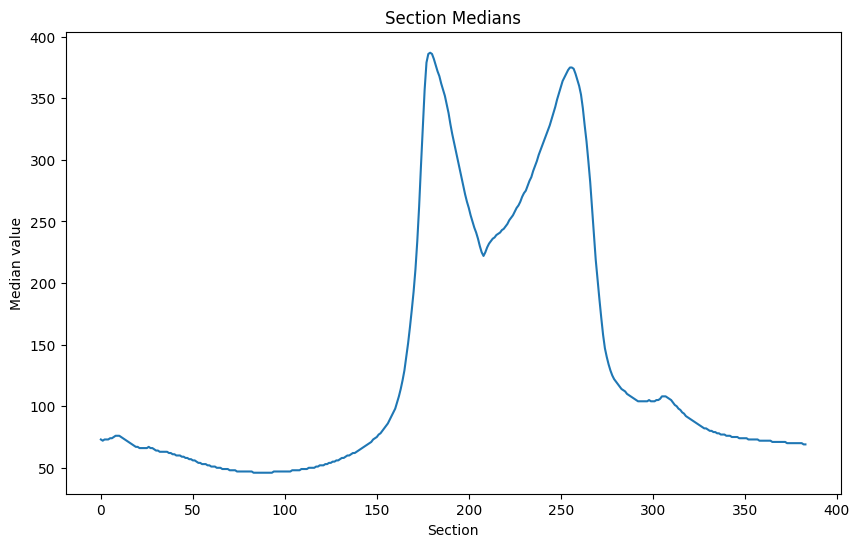

In [17]:
# Calculate the mean intensity of each section
section_medians_org = numpy.median(mipdata, axis=(1,2))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(section_medians_org)
plt.title('Section Medians')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()


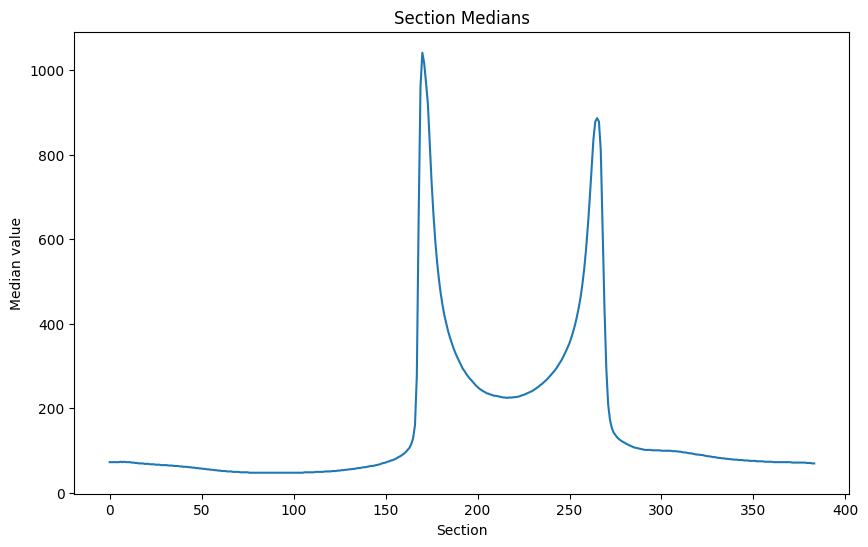

In [18]:
# Mask the zero values
masked_data = numpy.ma.masked_equal(flatten_data, 0)

# Compute the median for non-zero values along the specified axes
section_medians = numpy.ma.median(masked_data, axis=(1, 2))
# section_medians = numpy.median(flatten_data, axis=(1,2))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(section_medians)
plt.title('Section Medians')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()


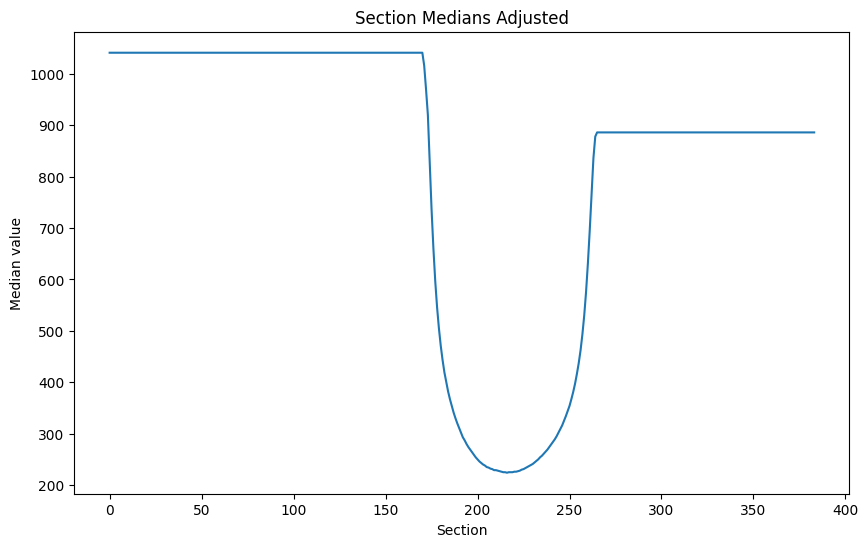

In [19]:
from scipy.signal import find_peaks

# Find peaks of the section_medians array
peaks, _ = find_peaks(section_medians, prominence=40)

section_medians_corrected = section_medians.copy()

# Apply peak value to the surface stacks
section_medians_corrected[0:peaks[0]] = section_medians[peaks[0]]
section_medians_corrected[peaks[-1]:] = section_medians[peaks[-1]]

plt.figure(figsize=(10, 6))
plt.plot(section_medians_corrected)
plt.title('Section Medians Adjusted')
plt.xlabel('Section')
plt.ylabel('Median value')
plt.show()

In [20]:
flatten_data.shape[0]

384

737.0

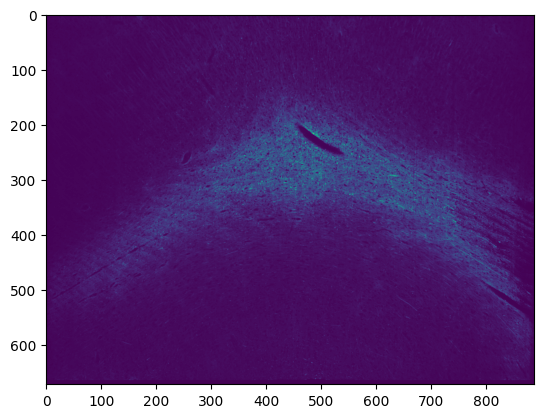

In [21]:
i = 175
plt.imshow(flatten_data[i])
section_medians_corrected[i]

In [30]:
# Calculate the desired mean intensity (e.g., the min of section medians)
desired_median = numpy.min(section_medians_corrected)

# Normalize each section to the desired mean intensity
normalized_stack = flatten_data.copy()
for i in range(flatten_data.shape[0]):
    normalized_stack[i] = (flatten_data[i] / section_medians_corrected[i]) * desired_median


In [63]:
write_array_to_tiff("flatten_v4_ic.tif",normalized_stack)

/tmp/ipykernel_2249591/3376891948.py:5: UserWarning: flatten_v4_ic.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


## experiment with chuncked processing

In [23]:
# global median
desired_median

30000

In [24]:
def intensity_correction(chunk, global_median, prominence=40):
    # Calculate the mean intensity of each section
    masked_data = numpy.ma.masked_equal(chunk, 0)

    # Compute the median for non-zero values along the specified axes
    section_medians = numpy.ma.median(masked_data, axis=(1, 2))
    # section_medians = numpy.median(chunk, axis=(1,2))
    # find the peaks
    peaks, _ = find_peaks(section_medians, prominence=40)
    section_medians_corrected = section_medians.copy()

    # Apply peak value to the surface stacks
    section_medians_corrected[0:peaks[0]] = section_medians[peaks[0]]
    section_medians_corrected[peaks[-1]:] = section_medians[peaks[-1]]

    # normalize the stack
    normalized_chunk = chunk.copy()
    for i in range(chunk.shape[0]):
        normalized_chunk[i] = (chunk[i] / section_medians_corrected[i]) * global_median
    return normalized_chunk

def process_chunks(volume, chunk_size, global_median):
    z_dim, y_dim, x_dim = volume.shape
    normalized_volume = numpy.zeros_like(volume)
    
    for z in range(0, z_dim, chunk_size):
        for y in range(0, y_dim, chunk_size):
            for x in range(0, x_dim, chunk_size):
                z_end = min(z + chunk_size, z_dim)
                y_end = min(y + chunk_size, y_dim)
                x_end = min(x + chunk_size, x_dim)
                
                chunk = volume[z:z_end, y:y_end, x:x_end]
                normalized_chunk = intensity_correction(chunk, global_median)
                
                normalized_volume[z:z_end, y:y_end, x:x_end] = normalized_chunk
    
    return normalized_volume

In [26]:
num_chunks = 20
volume = flatten_data
z_dim, y_dim, x_dim = volume.shape

# Calculate chunk size based on the number of chunks
# z_chunk_size = z_dim // num_chunks
y_chunk_size = y_dim // num_chunks
x_chunk_size = x_dim // num_chunks

corrected_volume = numpy.zeros_like(volume)

# for z in range(0, z_dim, z_chunk_size):
for y in range(0, y_dim, y_chunk_size):
    for x in range(0, x_dim, x_chunk_size):
        # z_end = min(z + z_chunk_size, z_dim)
        y_end = min(y + y_chunk_size, y_dim)
        x_end = min(x + x_chunk_size, x_dim)
        
        chunk = volume[:, y:y_end, x:x_end]
        corrected_chunk = intensity_correction(chunk, desired_median)
        
        corrected_volume[:, y:y_end, x:x_end] = corrected_chunk

In [27]:
chunk.shape[0]

384

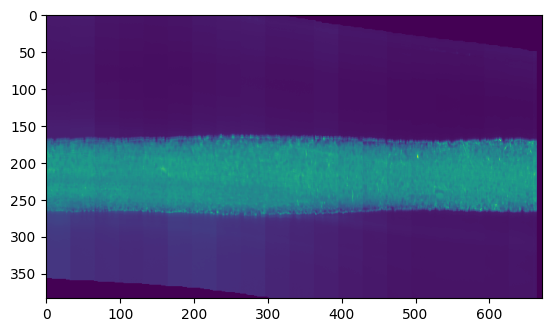

In [28]:
plt.imshow(corrected_volume[:,:,0])

In [29]:
write_array_to_tiff("flatten_v4_ic_highMed_chunked_20.tif",corrected_volume)

/tmp/ipykernel_564557/3376891948.py:5: UserWarning: flatten_v4_ic_highMed_chunked_20.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


## experiment with threshold based methods

In [31]:
import argschema
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import scipy.ndimage as ndimage
from argschema.fields import Str, Float
import matplotlib.pyplot as plt
import tensorstore as ts

# add the path to the module
import sys
sys.path.append('/home/wanqing.yu/AC_Project/packages/axonal_connectomics/')
from acpreprocessing.utils import io, convert

def ndfilter(img,sig=3):
    img = ndimage.gaussian_filter(img, sigma=(sig, sig, 5), order=0)
    return img

def flatten_bottom(img, bottom):
    """
    shift the height of each pixel to align the bottom of the section
    :param img: 3d array
    :param bottom: 2d array, int, indices of bottom surface
    :return imgb: 3d img, same size as img,
    """

    if len(img.shape) != 3:
        raise ValueError('input array should be 3d.')

    if bottom.shape != (img.shape[1], img.shape[2]):
        raise ValueError('the shape of top should be the same size as each plane in img.')

    imgb = np.zeros(img.shape, dtype=img.dtype)

    z, y, x = img.shape

    for yi in range(y):
        for xi in range(x):
            b = bottom[yi, xi]
            if b!= 0:
                col = img[:b, yi, xi]
                imgb[-len(col):, yi, xi] = col

    imgb = imgb[-np.amax(bottom):, :, :]

    return imgb


def flatten_top(img, top):
    """
    shift the height of each pixel to align the top of the section
    :param img: 3d array
    :param top: 2d array, int, indices of top surface
    :return imgft: 3d img, same size as img,
    """

    if len(img.shape) != 3:
        raise ValueError('input array should be 3d.')

    if top.shape != (img.shape[1], img.shape[2]):
        raise ValueError('the shape of top should be the same size as each plane in img.')

    imgt = np.zeros(img.shape, dtype=img.dtype)

    z, y, x = img.shape

    for yi in range(y):
        for xi in range(x):
            t = top[yi, xi]
            col = img[t:, yi, xi]
            imgt[:len(col), yi, xi] = col

    #imgt = imgt[-(z-np.amin(top)):, :, :]
    return imgt

def up_crossings(data, threshold=0):
    """
    find the index where the data up cross the threshold. return the indices of all up crossings (the onset data point
    that is greater than threshold, 1d-array). The input data should be 1d array.
    """
    if len(data.shape) != 1:
        raise ValueError('Input data should be 1-d array.')

    pos = data > threshold
    return (~pos[:-1] & pos[1:]).nonzero()[0] + 1

def down_crossings(data, threshold=0):
    """
    find the index where the data down cross the threshold. return the indices of all down crossings (the onset data
    point that is less than threshold, 1d-array). The input data should be 1d array.
    """
    if len(data.shape) != 1:
        raise ValueError('Input data should be 1-d array.')

    pos = data < threshold
    return (~pos[:-1] & pos[1:]).nonzero()[0] + 1

def find_surface(img, surface_thr, top_buffer = 0, bot_buffer = 0, is_plot=True):
    """
    :param img: 3d array, ZYX, assume small z = top; large z = bottom
    :param surface_thr: [0, 1], threshold for detecting surface
    :return top: 2d array, same size as each plane in img, z index of top surface
    :return bot: 2d array, same size as each plane in img, z index of bottom surface
    """

    if len(img.shape) != 3:
        raise ValueError('input array should be 3d.')

    z, y, x = img.shape
    top = np.zeros((y, x), dtype=int)
    bot = np.ones((y, x), dtype=int) * z

    for yi in range(y):
        for xi in range(x):
            curr_t = img[:, yi, xi]
            mx = curr_t.max()
            mn = curr_t.min()
            
            if mx != mn:
                curr_t = (curr_t - mn) / (mx - mn)

                if curr_t[0] < surface_thr:
                    curr_top = up_crossings(curr_t, surface_thr)
                    curr_top = curr_top + top_buffer
                    if len(curr_top) != 0:
                        top[yi, xi] = curr_top[0]

                if curr_t[-1] < surface_thr:
                    curr_bot = down_crossings(curr_t, surface_thr)
                    curr_bot = curr_bot+bot_buffer
                    if len(curr_bot) != 0:
                        bot[yi, xi] = curr_bot[-1]
                        
    return top, bot

###added codec parameter
def create_tensor(fpath, arr_shape, driver='zarr3', store='file', dtype='float32', fill_value=-np.inf, 
                       chunk_shape=(64, 64, 64), res=[1,1,1], scale=0, arr=None, AWS_param=None, encoding='raw', codec=None):
    """Create a tensorstore object, with optional setting of array
       driver: Type of file, including zarr, n5, precomputed
       store: Type of source, including file, in-memory, s3
       AWS Key, AWS_Secret_Key: Only applicable to s3 store
    """
    if 'int' in str(dtype):
        fill_value=0
    if isinstance(arr, np.ndarray):
        arr = arr.astype(dtype)
    kvstore = {"driver": store,"path": fpath}
    if store == 's3':
        bucket,path = split_s3_path(fpath)
        kvstore = {"driver": "s3","bucket": bucket ,"path": path}
        if AWS_param:
            kvstore.update({"aws_region": AWS_param.region})
            if hasattr(AWS_param, "endpoint_url"):
                kvstore.update({"endpoint": AWS_param.endpoint_url})
            cred = {"aws_credentials":{"profile": AWS_param.profile}}
            if hasattr(AWS_param, "credential_file"):
                cred = {"aws_credentials":{"profile": AWS_param.profile, 
                                           "filename": AWS_param.credential_file['filename']}}
            kvstore.update(cred)

    if driver in ['zarr','zarr3','n5']:
        fill_value=None if driver=='n5' else fill_value
        dic = {'driver': driver,'kvstore': kvstore}
        if codec:
            dic.update(codec)
        out_arr = ts.open(dic,
         dtype=dtype,
         fill_value=fill_value,
         chunk_layout=ts.ChunkLayout(chunk_shape=chunk_shape),
         create=True,
         shape=list(arr_shape)).result()

    if driver == 'neuroglancer_precomputed':
        arr_shape=list(arr_shape)+[1] if len(arr_shape)==3 else arr_shape
        out_arr = ts.open(
                    {
                        "driver": "neuroglancer_precomputed",
                        "kvstore": kvstore,
                        "scale_metadata": {
                            "resolution": res,
                            "chunk_size": list(chunk_shape),
                            "encoding": encoding,
                            "key": "s" + str(scale)
                        },
                    'delete_existing' : True,
                    },
                    create=True,
                    dtype=dtype,
                    domain=ts.IndexDomain(
                        shape=list(list(arr_shape)),
                    )).result()

    if isinstance(arr, np.ndarray):
        out_arr.write(arr).result()

    return out_arr

def open_tensor(fpath, driver='zarr3', store='file', AWS_param=None, bytes_limit= 100_000_000, codec=None):
    """Open a tensorstore object.
       driver: Type of file, including zarr, n5, precomputed
       store: Type of source, including file, s3
       AWS_client: Only applicable to s3 store
    """
    kvstore = {"driver": store,"path": fpath}
    if store == 's3':
        bucket,path = split_s3_path(fpath)
        kvstore = {"driver": "s3","bucket": bucket ,"path": path}
        if AWS_param:
            kvstore.update({"aws_region": AWS_param.region})
            if hasattr(AWS_param, "endpoint_url"):
                kvstore.update({"endpoint": AWS_param.endpoint_url})
            cred = {"aws_credentials":{"profile": AWS_param.profile}}
            if hasattr(AWS_param, "credential_file"):
                cred = {"aws_credentials":{"profile": AWS_param.profile, 
                                           "filename": AWS_param.credential_file['filename']}}
            kvstore.update(cred)
    #Load tensorstore array
    dic = {
         'driver':
             driver,
         'kvstore': kvstore,
     # Use 100MB in-memory cache.
         'context': {
             'cache_pool': {
                 'total_bytes_limit': bytes_limit
             }
         },
         'recheck_cached_data':'open'}
    if codec:
        dic.update(codec)
    dataset_future = ts.open(dic)
    return dataset_future.result()

def create_mask(top, bottom, shape):
    """
    :param top: 2d array, int, indices of top surface
    :param bottom: 2d array, int, indices of bottom surface
    :param shape: 3d tuple, dimensions of array, ZYX
    :return bot: 2d array, same size as each plane in img, z index of bottom surface
    """
    total = 0
    mask = np.zeros(shape).astype('uint32')
    for y in range(shape[1]):
        for x in range(shape[2]):
            zmin,zmax = top[y][x], bottom[y][x]
            total += zmax-zmin
            mask[zmin:zmax,y,x] = 1
    
    print("% Pixels Masked:",100-(total/(shape[0]*shape[1]*shape[2]))*100)
    return mask

In [38]:
# find image surfaces and create mask
top_test,bottom_test = find_surface(mipdata, .1, is_plot=True)
# smooth the surface with median filter
top_smooth = median_filter(top_test, size=25)
bottom_smooth = median_filter(bottom_test, size=25)

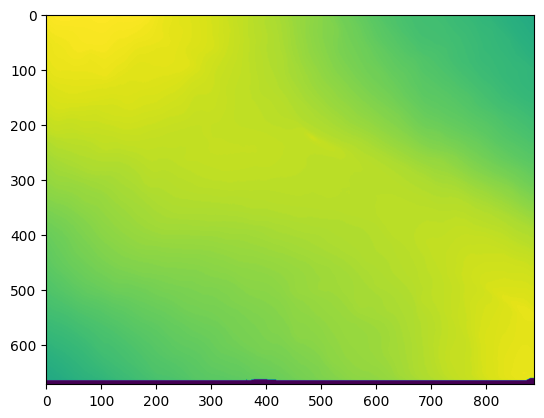

In [39]:
plt.imshow(top_smooth)

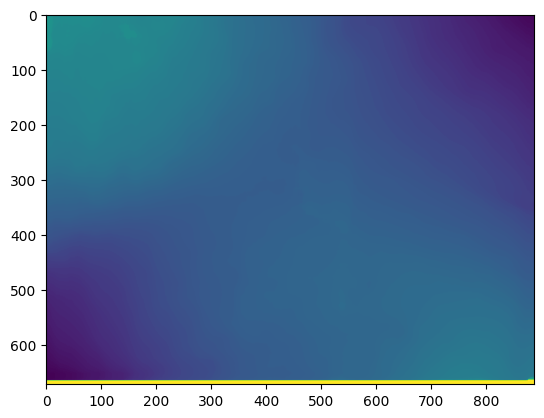

In [40]:
plt.imshow(bottom_smooth)

% Pixels Masked: 72.69757943280892


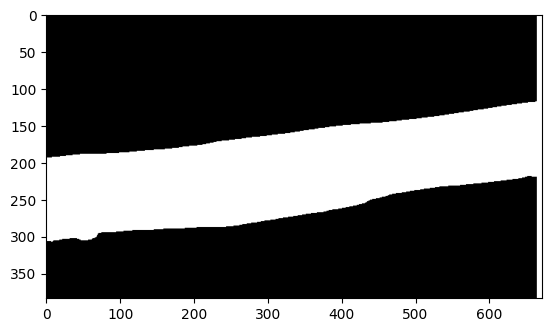

In [42]:
mask_test = create_mask(top_smooth,bottom_smooth,(mipdata.shape))
plt.imshow(mask_test[:,:,0], cmap='gray')

In [48]:
# masked stack
masked_stack = mipdata * mask_test
plt.imshow(masked_stack[:,:,5], cmap='gray')

In [45]:
masked_stack.shape

(384, 672, 888)

In [44]:
write_array_to_tiff("masked_mip4.tif",masked_stack)

/tmp/ipykernel_564557/3376891948.py:5: UserWarning: masked_mip4.tif is a low contrast image
  imsave(tiffpath,arr[i,...],append=True,bigtiff=True)


### find the mask for the flattened data

In [47]:
# find image surfaces and create mask
top_flat,bottom_flat = find_surface(flatten_data, .5, is_plot=True)
# smooth the surface with median filter


KeyboardInterrupt: 

In [ ]:
top_flat_smooth = median_filter(top_flat, size=25)
bottom_flat_smooth = median_filter(bottom_flat, size=25)

In [ ]:
plt.imshow(top_flat_smooth)

In [ ]:
plt.imshow(bottom_flat_smooth)